In [11]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from src.ingestion.load_kaggle import load_data

df = load_data("../data/raw/creditcard.csv")
df.head()


c:\Users\PC\Desktop\Programacion\Estudio\fraud-detection\.venv\Lib\site-packages\pandera\_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


,transaction_id,ts,user_id,amount,merchant,country,device_id,payment_method,label
0,0,2024-01-01 00:00:00,861,149.62,netflix,US,6763,debit,0
1,1,2024-01-01 00:00:01,4988,2.69,netflix,BR,2962,credit,0
2,2,2024-01-01 00:00:02,4740,378.66,uber,MX,9565,credit,0
3,3,2024-01-01 00:00:03,1018,123.50,uber,CO,9181,credit,0
4,4,2024-01-01 00:00:04,2489,69.99,walmart,US,5489,debit,0


In [3]:
df.dtypes

transaction_id            object
ts                datetime64[ns]
user_id                   object
amount                   float64
merchant                  object
country                   object
device_id                 object
payment_method            object
label                      int64
dtype: object

# Size and Balance

In [4]:
df.shape


(284807, 9)

In [8]:
fraud_rate = df['label'].mean()
print(fraud_rate*100)

0.1727485630620034


The mean of the 'label' column is 0.0017, which indicates that only 0.17% of the samples in our dataset belong to the positive class. This confirms we are dealing with an extremely imbalanced dataset.

In this scenario, Accuracy is a misleading metric. For instance, if we were to build a 'naive' model that predicts '0' for every single case without even looking at the data, it would achieve an Accuracy of 99.83%. Despite this nearly perfect score, the model would be completely useless for our objectives, as it would fail to detect a single instance of the minority class.

<function matplotlib.pyplot.show(close=None, block=None)>

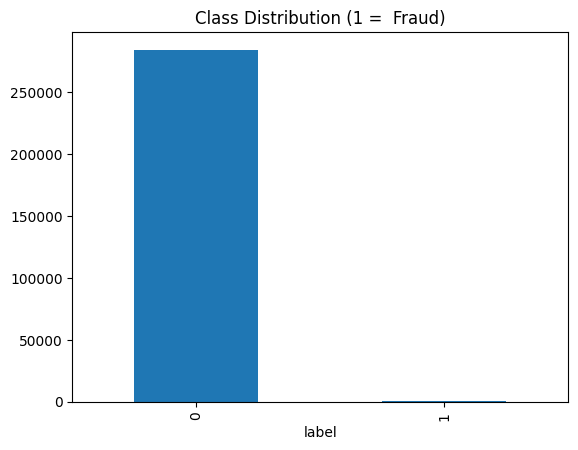

In [12]:
df['label'].value_counts().plot(kind = 'bar')
plt.title('Class Distribution (1 =  Fraud)')
plt.show

This class distribution plot provides visual confirmation of the extreme data imbalance previously mentioned. The minority class (Fraud) is virtually negligible compared to the majority class. Based on this evidence, we can entirely rule out Accuracy as a valid evaluation metric, as any model that completely ignores fraud cases would still report a misleadingly high accuracy score.

# Amount Distribution (Fraud vs. Normal)

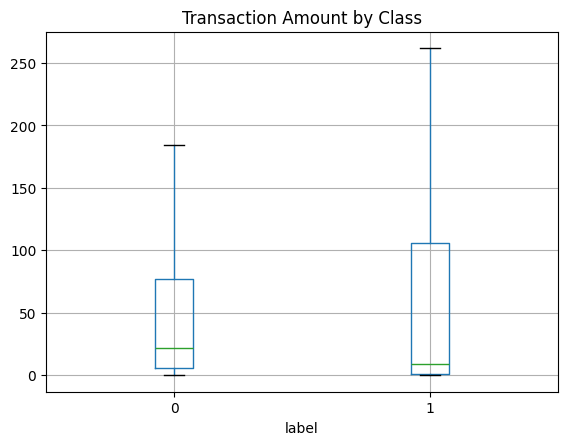

In [14]:
df.boxplot(column = 'amount', by = 'label', showfliers = False)
plt.title("Transaction Amount by Class")
plt.suptitle("")
plt.show()

The boxplots reveal that fraud occurs across both price spectrums. Although the median amount for fraud is lower than for legitimate transactions, the interquartile range and outliers (>$250) demonstrate much higher dispersion. This suggests that fraud does not follow a fixed amount pattern but is instead erratically distributed across different values.

# Basic Temporal Analysis

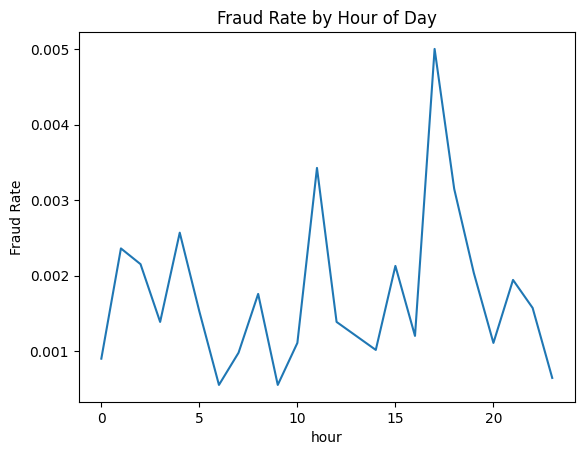

In [ ]:
df["hour"] = df["ts"].dt.hour

df.groupby("hour")["label"].mean().plot()
plt.title("Fraud Rate by Hour of Day")
plt.ylabel("Fraud Rate")
plt.show()

The fraud rate is not uniform throughout the day. We identified a significant peak at 17:00, where the fraud probability reaches 0.5%. Additionally, there is a notable spike during the early morning hours, which suggests fraudulent activity occurs when legitimate users are less likely to monitor their accounts. These fluctuations confirm that time is a relevant feature for our predictive model.

# Leakage

Are variables V1..V28 interpretable?

No. The variables V1 through V28 correspond to principal components (PCA) and do not have a direct interpretation from a business or financial domain perspective. It is not possible to explain what each variable represents or how it impacts a real-world decision.

Are there variables that would not exist in real-time?

Yes. Since they are the result of a PCA transformation applied to the entire dataset, these variables depend on global information that includes future observations. In a real production scenario, this type of information would not be available at the moment a prediction is made.

Was this dataset transformed with PCA using all the data?

Yes. According to the official dataset description, the variables V1–V28 were generated via PCA by the dataset provider, using all available information. The transformation pipeline is not provided, and it is not possible to recalculate the PCA using only historical data.

# Minimun Baseline

In [21]:
threshold = df['amount'].quantile(0.995)
df['baseline_pred'] = (df['amount'] > threshold.astype(int))

from sklearn.metrics import precision_score, recall_score

precision_score(df['label'],df['baseline_pred'])

0.002097902097902098

In [22]:
recall_score(df['label'],df['baseline_pred'])

0.006097560975609756

The heuristic baseline (flagging the top 0.5% by amount) yielded a Precision of 0.21% and a Recall of 0.61%. These results demonstrate that transaction amount alone is a poor predictor of fraud in this dataset. The extremely low Recall suggests that most fraudulent activities involve smaller amounts that do not trigger 'high-value' alerts. This clearly justifies the transition to a Machine Learning approach, as we need to leverage the hidden patterns in variables V1-V28 to achieve meaningful detection rates.